# SPM Figure 1

Code for the creation of the datasets and plotting of SPM Figure 1. 

Written by: Richard Millar, 2018 (richard.millar@ouce.ox.ac.uk),

Edited by: Stuart Jenkins, 2018 (stuart.jenkins@wadham.ox.ac.uk).

## Run code

Code to import the required datasets (from subfolder './Data/'), scale the forcings correctly, run through to temperature datasets where necessary and save the relevent outputs ready for the plotting sequence.
Run code split into two classes:

1) pathways_data()

2) Timeseries_fig_data()
    
### Pathways_data class
 
#### Functions in class:

- \_\_init\_\_(...):
    - loads the RCP8.5 RF dataset from data subfolder,
    - loads contrails data using load_contrails_rf() function,
    - runs conb_rf_comps() function to combine radiative forcings.
- comb_rf_combs(...):
    - adds attributes to the pathways_data object of summed RF contributions for gaussian RFs, CO2, BC, aerosols.
- create_climateresp_dist(...):
    - create the sampling of the climate response parameter distributions,
    - uses 'shape' attribute in function call to decide whether parameter distributions are gaussian or lognormal,
    - uses inputted likely range for TCR and ECS to define parameter distributions and samples them for given cdf values,
    - uses cdf likely above and likely below range and fitted $\mu$ and $\sigma$ values for TCR and ECS to return arrays of TCR abd ECS values.
- create_gauss_scalingfactors(...)
    - calculates the required gaussian forcers scaling factors to make the 2011 values and likely range the same as AR5 values.
- create_aerosol_scalingfactors(...)
    - create the aerosol forcing scalings to make the warming due to aerosols the AR5 quoted values in 2017.
- integ_scenarios(...)
    - for each scenario run the total forcing with each TCR and ECS value,
    - find the temperature response to this total forcing, and save it as an anomaly (baselined at 1861-1880) for access elsewhere.
- linear_decline_tozero(...)
    - main function of the class. Used to generate the future pathways for linear decline of CO2 emissions to zero,
    - input two arrays, co2_times and co2_fracs which give times and 'fractions of 2020 co2 emissions' which are interpolated to get annual emissions values,
    - run over array 'slcp_targs'. If slcp_targs[i] value is > 0.7 non-CO2 forcing constant after 2030. If slcp[i] value is < 0.5 forcing is left as scenario non-CO2 forcing after 2020. Set to constant at 2100 value after 2100. 
- calc_cc_uncertainty(...)
    - calculate the adaptive blended temperature pathways to get to a 2100 goal and their compatible CO2 emissions,
    - sets a gaussian which spans the CMIP5 ratio of rC:r0 with central value of 1.0. Samples this distribution for the relevent cdf values to get the relevent rC:r0 ratio for that cdf value,
    - uses the root function on a backed out emissions timeseries to fit the necessary carbon cycle parameter values to find correct annual CO2 emissions value in 2017 for each scenario input and TCR/ECS value. Saves necessary carbon cycle parameters to object attributes.
- save_plotdata(...)
    - saves data necessary for plotting to a '.h5' filetype,
    - saved arrays are: years, temp_zero, llems_zero, slcp_zero.
- calc_tcre(...)
    - calculates an estimate of the TCRE value for that given TCR, ECS and carbon cycle parameter choice. 
- print_params(...)
    - prints useful parameters for review to a .txt file,
    - saves parameters are: cdf value, TCR, ECS, TCRE, rf_aero_2011, rf_tot_2011.
    
#### Brief description of pathways_data class:

Called in the run twice, once to produce linear CO2 emissions decline to zero at 2055, and again to produce a linear CO2 decline to zero at 2040 (using 'linear_decline_tozero' function). For each CO2 pathway the non_CO2 forcing is created in two configurations. One has the forcing follows the shape of data contained in './Data/F_oth.txt' between 2020-2100, and after 2100 it is constant at 2100 value. The other has forcing following shape of 'F_oth.txt' file between 2020-2030, and then has the forcing constant at 2030 value thereafter. 

Output files are time/date-stamped and labelled 'spmfig_plotdata_te_datetimestamp.h5' and 'spmfig_plotdata_lb_datetimestamp.h5'.

### Timeseries_fig_data class

#### Functions in class:

- \_\_init\_\_(...)
    - imports the HADCRUT4, GISTEMP, NOAA, Berkeley and HadCRUT4-CW temperature datasets,
    - sets data to the same common reference period, so they roughly overlay,
    - calculate the max, min and mean observed temperatures from the datasets for each month and save as object attribute.
- calc_gmst_gwi(...)
    - calculate the AWI and NWI of each GMST dataset relative to the baseperiod and also for the mean of the datasets,
    - uses erxternally defined calc_gwi() function to find NWI and AWI for each dataset.
- load_paleodata(...)
    - loads the paleo dataset from './Data/marcott_paleo.csv'. Express relative to the correct baseline period,
    - returns attribute of timeseries_fig_data object with required paleo_data array.
- load_cmip5_data(...)
    - imports the RCP8.5 blended type timeseries and rebaselines them.
- load_ar5_projections(...)
    - calculates the AR5 projected temperatures for 2030 from gradients of temperature over ~20 year period.
- print_text_nums(...)
    - print useful numbers from temperature timeseries, so they can be easily accessed for report. 
- save_faqdata(...)
    - saves the min, max and mean temperature arrays from the inputted datasets.
- save_plotdata(...)
    - saves the necessary arrays for plotting to '.h5' filetype,
    - saved arrays are: gmst, paleodata, cmip5_data, ar5_proj.
    
#### Brief description of timeseries_fig_data class:

Called once in the run section. Produces the necessary observed temperature datasets for plotting over the historical period, all baselined to a common reference period. Included temperature datasets are: HADCRUT4, GISTEMP, NOAA, Berkeley, HadCRUT4-CW. 

Output files are time/date-stamped and labelled 'fig1.1_plotdata_datetimestamp.h5'.

In [70]:
####################################################################
#IMPORT LIBRARY STATEMENTS 
####################################################################
#Compute libraries
from scipy.ndimage.filters import gaussian_filter1d
from scipy.special import erf, erfinv
from scipy.optimize import root
from scipy.stats import norm, beta
import os
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import zipfile
from fair_scm import *
import datetime
import h5py
import copy
import sys
import deepdish as dd
import numpy as np
from pandas import DataFrame
from statsmodels.api import OLS
import statsmodels.tools.tools


#Data from the assessment... 
temp_ref_ar5 = 0.63 #Updated value for AR5 near-term reference period 
temp_ref_sr15 = 0.87 #Assessed value for SR1.5 near-term reference period 
ref_uncert_ar5 = 0.06 #Uncertainty in AR5 ref period 
ref_uncert_sr15 = 0.12 #Uncertainty in SR1.5 ref period 

In [153]:
# Externally defined function 'calc_gwi(...)'.
#     Imports forcing data from file './Data/Annualforcings_Mar2014_GHGrevised.txt'.
#     Calculates the temperature response from inputted natural and anthropogenic forcing (t_anthro, t_nat),
#       rebaselined to mean value between years base_low and base_high. 
#     Use OLS regression to fit the scalings for natural and anthropogenic temperature response over timeseries.
#     return scaled t_anthro (awi) and t_nat (nwi).

def calc_gwi(obs,obs_years,reg_type='mon',base_low=1850.,base_high=1900):
    
    #Express the observations relative to the base period 
    obs = obs - np.mean(obs[np.logical_and(obs_years>=base_low,obs_years<(base_high+1))])

    #Load the best estimate forcings from Piers
    forc_file = './Data/Annualforcings_Mar2014_GHGrevised.txt'
    data = np.genfromtxt(forc_file,skip_header=4)
    years = data[:,0]
    tot_forc = data[:,13]
    ant_forc = data[:,14]

    #Integrate anthropogenic and natural forcing with standard FAIR parameters
    #t_nat = fair_scm(tot_forc-ant_forc,mode='forcing_driven')
    #t_anthro = fair_scm(ant_forc,mode='forcing_driven')
    C, t_nat = fair_scm(other_rf=tot_forc-ant_forc)
    C, t_anthro = fair_scm(other_rf=ant_forc)
    #Express relative to the centre of the base period
    #t_nat = t_nat - np.mean(t_nat[np.logical_and(years>=1870,years<1880)])
    #t_anthro = t_anthro - np.mean(t_anthro[np.logical_and(years>=1870,years<1880)])
    t_nat = t_nat - np.mean(t_nat[np.logical_and(years>=1850,years<1901)])
    t_anthro = t_anthro - np.mean(t_anthro[np.logical_and(years>=1850,years<1901)])

    #Interpolate the annual forced responses to the grid of the observed data
    if reg_type !='mon':
        t_nat = np.interp(obs_years+0.5, years+0.5, t_nat)
        t_anthro = np.interp(obs_years+0.5, years+0.5, t_anthro)
    else:
        t_nat = np.interp(obs_years, years+0.5, t_nat)
        t_anthro = np.interp(obs_years, years+0.5, t_anthro)

    #Linearly project the final half year
    t_anthro[obs_years>(years[-1]+0.5)] = 12*(t_anthro[obs_years<=(years[-1]+0.5)][-1] - t_anthro[obs_years<=(years[-1]+0.5)][-2]) * (obs_years[obs_years>(years[-1]+0.5)] - obs_years[obs_years<=(years[-1]+0.5)][-1]) \
    +t_anthro[obs_years<=(years[-1]+0.5)][-1]
    t_nat[obs_years>(years[-1]+0.5)] = 12*(t_nat[obs_years<=(years[-1]+0.5)][-1] - t_nat[obs_years<=(years[-1]+0.5)][-2]) * (obs_years[obs_years>(years[-1]+0.5)] - obs_years[obs_years<=(years[-1]+0.5)][-1]) \
    +t_nat[obs_years<=(years[-1]+0.5)][-1]

    #OLS regression of observations data on natural and anthropogenic warming with a constant
    y = np.copy(obs)
    x = DataFrame({'x1': (t_anthro), 'x2': (t_nat)})
    x = statsmodels.tools.tools.add_constant(x)
    model = OLS(y, x)
    result = model.fit()
    sf = result.params

    #Form scaled anthropgenic warming index
    awi = t_anthro * sf['x1']
    #Scaled natural warming index
    nwi = t_nat * sf['x2']
    #Scaled total externally forced warming index
    gwi = awi + nwi

    return awi, nwi

In [72]:
class timeseries_fig_data():
    """ Class containing main data time series used in plotting Fig 1.1 of SR1.5
    """
    
    def __init__(self,base_low=1850.,base_high=1900.,com_ref_low=1880.,com_ref_high=2017.,temp_freq='mon'):
        
        #Specify the GMST best-estimate temperature timeseries files 
        self.gmst_files = {'HadCRUT4':'./Data/HadCRUT.4.6.0.0.monthly_ns_avg.txt',
        'GISTEMP':'./Data/GLB.Ts+dSST.csv',
        'NOAA':'./Data/aravg.mon.land_ocean.90S.90N.v4.0.1.201803.asc',
        'Berkeley':'./Data/Land_and_Ocean_complete.txt',
        'HadCRUT4-CW':'./Data/had4_krig_v2_0_0.txt'}
        
        self.gmst_names = self.gmst_files.keys()
        
        self.base_low = base_low
        self.base_high = base_high
        self.temp_freq = temp_freq
        self.com_ref_low = com_ref_low
        self.com_ref_high = com_ref_high
        
        self.gmst = {}
        
        years_com = np.arange(1850. + 1./24,1850. + 1./24 + (2020)*1./12,1.0/12)[:-1]
        
        for key in self.gmst_names:
            
            print key
            
            if key in ['HadCRUT4','HadCRUT4-CW']:
                data = np.genfromtxt(self.gmst_files[key])
                temps = data[:,1]
                years = years_com[:len(temps)]
                
            if key in ['GISTEMP']:
                f_giss = open(self.gmst_files[key],'r')
                temps = []
                counter = 0
                for line in f_giss:
                  if counter>=2:
                      temps.extend([float(f) for f in line.split(',')[1:13] if f != '***'])
                  counter = counter + 1
                temps=np.array(temps)
                years = years_com[years_com>1880.][:len(temps)]
                
            if key in ['NOAA']:
                data = np.genfromtxt(self.gmst_files[key])
                temps = data[:,2]
                years = years_com[years_com>1880.][:len(temps)]
            
            if key in ['Berkeley']:
                data = np.genfromtxt(self.gmst_files[key])
                temps = data[:,2]
                years = years_com[:len(temps)]
                
                
            self.gmst[key] = {'Temp':temps,'Years':years}
            
        #Set the datasets to a common reference period        
        hc_ref = np.mean(self.gmst['HadCRUT4']['Temp'][np.logical_and(self.gmst['HadCRUT4']['Years']>=self.com_ref_low,
                        self.gmst['HadCRUT4']['Years']<(self.com_ref_high+1))]) - np.mean(self.gmst['HadCRUT4']['Temp'][np.logical_and(self.gmst['HadCRUT4']['Years']>=base_low,
                                                        self.gmst['HadCRUT4']['Years']<(base_high+1))])
        for key in self.gmst_names:
            self.gmst[key]['Temp'] = self.gmst[key]['Temp'][self.gmst[key]['Years'] < 2018.]
            self.gmst[key]['Years'] = self.gmst[key]['Years'][self.gmst[key]['Years'] < 2018.]
            #Express relative to a common base period
            self.gmst[key]['Temp'] = self.gmst[key]['Temp'] - np.mean(self.gmst[key]['Temp'][np.logical_and(self.gmst[key]['Years']>=self.com_ref_low,
                                                                      self.gmst[key]['Years']<(self.com_ref_high+1))])
            #Set NOAA and GISTEMP datasets relative to HadCRUT4 value over the base period 
            if key in ['NOAA','GISTEMP']:
                self.gmst[key]['Temp'] = self.gmst[key]['Temp'] + hc_ref
            else: 
                self.gmst[key]['Temp'] = self.gmst[key]['Temp'] - np.mean(self.gmst[key]['Temp'][np.logical_and(self.gmst[key]['Years']>=base_low,
                                                                                      self.gmst[key]['Years']<(base_high+1))])
                                                                                      
        #Calculate the max, min and mean obs in every month...
        obs_max = np.zeros_like(self.gmst['HadCRUT4']['Years'])
        obs_min = np.zeros_like(self.gmst['HadCRUT4']['Years'])
        obs_mean = np.zeros_like(self.gmst['HadCRUT4']['Years'])
        for y in range(0,len(self.gmst['HadCRUT4']['Years'])): 
            year_vals =[]
            #Loop over AR5 datasets and HadCRUT4-CW
            for ob in ['HadCRUT4','NOAA','GISTEMP','HadCRUT4-CW']:
                val = self.gmst[ob]['Temp'][self.gmst[ob]['Years']==self.gmst['HadCRUT4']['Years'][y]]
                if len(val)>0:
                    year_vals.append(val)
            obs_max[y] = np.max(year_vals)
            obs_min[y] = np.min(year_vals)
            obs_mean[y] = np.mean(year_vals)
        
        self.gmst['Temp-max'] = obs_max
        self.gmst['Temp-min'] = obs_min
        self.gmst['Temp-mean'] = obs_mean
        
            

        return 
        
    def calc_gmst_awi(self):
        
        #Calculate the AWI and NWI for each GMST dataset relative to the baseperiod and
        #also for the mean of the datasets 
        for key in self.gmst_names:
            awi, nwi = calc_gwi(self.gmst[key]['Temp'],self.gmst[key]['Years'],reg_type=self.temp_freq,
                                base_low=self.base_low,base_high=self.base_high)
            #Express AWI and NWI relative the mid-point of the period
            self.gmst[key]['AWI'] = awi 
            self.gmst[key]['NWI'] = nwi 
            
        #Calculte for the mean of the datasets
        awi, nwi = calc_gwi(self.gmst['Temp-mean'],self.gmst['HadCRUT4']['Years'],reg_type=self.temp_freq,
                            base_low=self.base_low,base_high=self.base_high)
        self.gmst['Temp-mean-AWI'] = awi 
        self.gmst['Temp-mean-NWI'] = nwi
                            
            
        return 
        
    def load_paleodata(self):
        
        #Load the paleo data
        p_data = np.genfromtxt('./Data/marcott_paleo.csv',delimiter=',',skip_header=3)
        p_years = p_data[:,0]
        p_temps = p_data[:,1]
        #Express relative to the selected reference period using HadCRUT4
        p_temps = p_temps + np.mean(self.gmst['HadCRUT4']['Temp'][np.logical_and(self.gmst['HadCRUT4']['Years']>=1961,
                                                    self.gmst['HadCRUT4']['Years']<1991)])
        #Select the paleo data from off the end of the HadCRUT4 record
        self.paleo_data = {}
        self.paleo_data['Temp'] = p_temps[p_years>-1*(1850 - 1950)]
        self.paleo_data['Years'] = p_years[p_years>-1*(1850 - 1950)]
        
        return
        
    def load_cmip5_data(self):
        
        
        cmip5_data={}
        cmip5_data['Years'] = np.arange(1861.,2100.) 
            
        cmip5_data['RCP8.5']={}
        #Load the Richardson et al masked/blended timeseries
        f = h5py.File('./Data/rcp85_blended_tseries.h5', 'r')
        global_data = f['global_series']
        blend_types = global_data.keys()
        #Select the model names that correspond to the r1i1p1 ensemble members
        model_names = [x.split('_')[0] for x in global_data['global-tas'].keys() if x[-6:]=='r1i1p1']
        temps = dict((option,{}) for option in model_names)
        for model in model_names:
            temps[model] = dict((bt,{}) for bt in blend_types)
            for bt in blend_types:
                temps[model][bt] = np.array(global_data[bt][model+'_r1i1p1'])
        #Take a mean of the ensemble
        for bt in blend_types:
            cmip5_data['RCP8.5'][bt] = np.mean(np.array([temps[model][bt] for model in model_names]),axis=0)
            #Add the difference between 1861-80 and base period
            cmip5_data['RCP8.5'][bt] = cmip5_data['RCP8.5'][bt] + np.mean(self.gmst['HadCRUT4']['Temp'][np.logical_and(self.gmst['HadCRUT4']['Years']>=1861,
                                                    self.gmst['HadCRUT4']['Years']<1881)])
        
        self.cmip5_data = cmip5_data
        
        return
        
    def load_ar5_projections(self):
        
        #Get data for IPCC 2030 projections
        year_a = 2026.0
        year_late_a = (1986+2006) / 2.0
        a_range = np.array([0.3,0.5*(0.3+0.7),0.7]) + temp_ref_ar5
        grads = (a_range - temp_ref_ar5) / (year_a - year_late_a)
        
        self.ar5_proj = {}

      
        self.ar5_proj['Years'] = np.arange(2016.0,2036.0)
        self.ar5_proj['Temp'] = temp_ref_ar5 + grads[:,np.newaxis]*(self.ar5_proj['Years'][np.newaxis,:] - year_late_a)
        self.proj_2030 = temp_ref_ar5 + grads[1]*(2030.0 - year_late_a)
        
        return
        
    def print_text_nums(self):
        """Write the numbers that are of use to the report into a file"""
        f_out = open('./fig1.1/output/ar5_presentday.txt','w')
        self.ar5_present = {}
        self.present_dec = {} 
        self.present_dec_attribdiff = {}
        f_out.write('Warming relative to '+str(self.base_low)+'-'+str(self.base_high)+' inclusive (offset using '+str(self.com_ref_low)+'-'+str(self.com_ref_high)+' average)\n')
        f_out.write('\t1986-2005\t2006-2015\tDifference\n')
        for mod in self.gmst_names:
            self.ar5_present[mod] = np.mean(self.gmst[mod]['Temp'][np.logical_and(self.gmst[mod]['Years']>1986.,self.gmst[mod]['Years']<2006.)])
            self.present_dec[mod] = np.mean(self.gmst[mod]['Temp'][np.logical_and(self.gmst[mod]['Years']>2006.,self.gmst[mod]['Years']<2016.)])
            f_out.write(mod+'\t'+str(self.ar5_present[mod])+'\t'+str(self.present_dec[mod])+'\t'+str(self.present_dec[mod]-self.ar5_present[mod])+'\n')
        
        f_out.write('Difference between observed and attributed warming 2006-2015\n')
        for mod in self.gmst_names:
            #Calculate the difference in warming between obs and attributed warming over 2006-2015
            self.present_dec_attribdiff[mod]= np.mean((self.gmst[mod]['Temp'] - self.gmst[mod]['AWI']-self.gmst[mod]['NWI'])[np.logical_and(self.gmst[mod]['Years']>2006.,self.gmst[mod]['Years']<2016.)])
            f_out.write(mod+'\t'+str(self.present_dec_attribdiff[mod])+'\n')
        f_out.close()
        
        
        return
        
    def save_faqdata(self):
        
        """Write the min and max obs data to a file for use in the FAQs"""
        f_out = open('./fig1.1/output/faq_data.csv','w')
        f_out.write('Year,Obs-max,Obs-min\n')
        for i in range(0,len(self.gmst['HadCRUT4']['Years'])):
            f_out.write(str(self.gmst['HadCRUT4']['Years'][i]))
            f_out.write(',')
            f_out.write(str(self.gmst['Temp-max'][i]))
            f_out.write(',')
            f_out.write(str(self.gmst['Temp-min'][i]))
            f_out.write('\n')
            
        f_out.close()
        
        return
        
    
        
    def save_plotdata(self):
        """ Save the plotting data to a file """
        #Combine all the data into a single dictionary
        comb_dict = {'Obs':self.gmst,'Anthrop':self.paleo_data,'CMIP5':self.cmip5_data,'AR5-proj':self.ar5_proj}
        
        #Write the data to a .h5 file
        now = datetime.datetime.now()
        dd.io.save('./spmfig/output/fig1.1_plotdata_'+now.strftime('%d%m%Y_%H:%M:%S')+'.h5', comb_dict, compression=None)
        
        return
    
    

In [73]:
# Externally defined function 'load_rcp_emissions(...)'.
#     load the file at location 'emms_file'. In this case the standard is RCP8.5 emissions timeseries.
#     returns 4 arrays: CO2 emissions, CH4 emissions, N2O emissions, years.

def load_rcp_emissions(emms_file):

  #Loads a CO2 emissions timeseries
  dt = np.dtype({'names':["YEARS","FossilCO2","OtherCO2","CH4","N2O","SOx","CO","NMVOC","NOx","BC","OC","NH3","CF4","C2F6","C6F14","HFC23","HFC32","HFC43_10","HFC125","HFC134a","HFC143a","HFC227ea","HFC245fa","SF6","CFC_11","CFC_12","CFC_113","CFC_114","CFC_115","CARB_TET","MCF","HCFC_22","HCFC_141B","HCFC_142B","HALON1211","HALON1202","HALON1301","HALON2402","CH3BR","CH3CL"],'formats':40*["f8"]})
  emm_data = np.genfromtxt(emms_file,skip_header=38,delimiter=',',dtype=dt)

  return emm_data['FossilCO2'] + emm_data['OtherCO2'] , emm_data['CH4'], emm_data['N2O'], emm_data['YEARS']

###############################################################

# Externally defined function 'analy_musig(...)'.
#     finds the mu and sigma values for a gaussian between the 5-95% bounds specified in function call.

def analy_musig(bound1,bound2):

  C = (np.sqrt(2.0)*erfinv((0.5-1.0/3.0)*2 - 1.0 ))
  K = erfinv((0.5+1.0/3.0)*2 - 1)*np.sqrt(2.0)

  mu_ans = ( K* np.log(bound1) - np.log(bound2))/(K/C -1) 
  sig_ans = (np.log(bound1) - mu_ans) / C
  
  mu_ans = ( np.log(bound1)*erfinv(2*(0.5+1.0/3.0)-1.0) - np.log(bound2)*erfinv(2*(0.5-1.0/3.0)-1.0)  ) / (erfinv(2*(0.5+1.0/3.0)-1.0) - erfinv(2*(0.5-1.0/3.0)-1.0))
  sig_ans = ( np.log(bound2) - mu_ans) / (np.sqrt(2.0)*erfinv(2*(0.5+1.0/3.0)-1.0)  )
  

  return mu_ans, sig_ans
  
###############################################################
    
# Externally defined function 'express_as_anom(...)'.
#     returns the inputted array x rebaselined to zero between the base_low and base_high years.
    
def express_as_anom(x,years,base_low=1861.,base_high=1880.):
    
    return x - np.mean(x[np.logical_and(years>=base_low,years<=base_high)])

###############################################################

# Externally defined function 'load_contrails_rf(...)'.
#     loads the contrails rf data from the file './Data/ipcc_tod_rftimeseries.txt'.
#     contrails forcing is assumed constant in the future as no data. 
#     returns rf_cont array.

def load_contrails_rf(years,datadir='./Data/'):
    
  rf_cont_file = datadir+'ipcc_tod_rftimeseries.txt'
  hist_rf_dat = np.genfromtxt(rf_cont_file,skip_header=4)
  #Contrail forcing assumed to be constant in future as no scenario data 
  rf_cont = 0.05*np.ones_like(years)
  rf_cont[years<=2011] = hist_rf_dat[15:,10]

  return rf_cont 
  
###############################################################
    
# Externally defined function 'load_rf_comps(...)'.
#     loads the radiative forcing contributions from the file 'rf_file'. 
#     If ar5_scale = True, the outputs are scaled so they match the 2011 values quoted in AR5.

def load_rf_comps(rf_file,ar5_scale=False):
    """Loads the components of RF from a spreadsheet (.csv) of the different components
    """
    
    dt = np.dtype({'names':["YEARS","TOTAL_INCLVOLCANIC_RF","VOLCANIC_ANNUAL_RF","SOLAR_RF","TOTAL_ANTHRO_RF","GHG_RF",
    "KYOTOGHG_RF","CO2CH4N2O_RF","CO2_RF","CH4_RF","N2O_RF","FGASSUM_RF","MHALOSUM_RF","CF4","C2F6","C6F14","HFC23","HFC32",
    "HFC43_10","HFC125","HFC134a","HFC143a","HFC227ea","HFC245fa","SF6","CFC_11","CFC_12","CFC_113","CFC_114","CFC_115",
    "CARB_TET","MCF","HCFC_22","HCFC_141B","HCFC_142B","HALON1211","HALON1202","HALON1301","HALON2402","CH3BR","CH3CL",
    "TOTAER_DIR_RF","OCI_RF","BCI_RF","SOXI_RF","NOXI_RF","BIOMASSAER_RF","MINERALDUST_RF","CLOUD_TOT_RF","STRATOZ_RF",
    "TROPOZ_RF","CH4OXSTRATH2O_RF","LANDUSE_RF","BCSNOW_RF"],'formats':54*["f8"]})
    forc_data = np.genfromtxt(rf_file,skip_header=59,delimiter=',',dtype=dt)
    
    years = forc_data["YEARS"]
    rf_co2 = forc_data["CO2_RF"]
    rf_wmghg = forc_data['GHG_RF']
    rf_owmghg = rf_wmghg - rf_co2
    rf_landuse = forc_data["LANDUSE_RF"]
    rf_bcos = forc_data["BCSNOW_RF"]
    rf_oz = (forc_data["TROPOZ_RF"]+forc_data["STRATOZ_RF"])
    rf_strath2o = forc_data["CH4OXSTRATH2O_RF"]
    rf_aero = (forc_data["TOTAER_DIR_RF"] + forc_data["CLOUD_TOT_RF"])

    rf_out = np.array([rf_co2,rf_owmghg,rf_oz,rf_strath2o,rf_landuse,rf_bcos,rf_aero])
    
    rf_solar = forc_data["SOLAR_RF"]
    #Smooth future solar cycle forcing with a ten year gaussian filter
    rf_solar[years>2015] = gaussian_filter1d(forc_data["SOLAR_RF"][years>2015],10)
    
    rf_nat = np.array([rf_solar,forc_data["VOLCANIC_ANNUAL_RF"]])
    
    if ar5_scale == True:
        #Scale the anthropgogenic forcing to get the AR5 values in 2011
        # Entry 1 in list is the total ERF for WMGHG
        rf_2011_mid = np.array([1.82,2.83,0.35,0.07,-0.15,0.04,-0.9])
        #Set the first component to be for other WMGHG (not including CO2) only
        rf_2011_mid[1] = rf_2011_mid[1] - rf_2011_mid[0]
        #Find the set of scaling factors needed to get AR5 forcings in 2011
        req_sf = rf_2011_mid[:,np.newaxis] / rf_out[:,years==2011]
        rf_out = req_sf * rf_out
        
        #Scale the solar forcing to AR5 values, leave volcanic as RCP timeseries
        rf_nat[0] = 0.05 / rf_nat[0,years==2011] * rf_nat[0]
        return rf_out, rf_nat, req_sf
    else:
        return rf_out, rf_nat
    
    
    #Add on the AR5 forcings before 2015
    dt = np.dtype({'names':["YEARS","CO2_RF","OWMGHG_RF","TROPOZ_RF","STRATOZ_RF","TOTAER_DIR_RF","TOTAER_RF","LANDUSE_RF",
    "CH4OXSTRATH2O_RF","BCSNOW_RF","CONTRAIL_RF","SOLAR_RF","VOLCANIC_ANNUAL_RF"],'formats':13*["f8"]})
    forc_data = np.genfromtxt('./Data/ipcc_tod_rftimeseries.txt',skip_header=4,dtype=dt)
    
    ar5_years = forc_data["YEARS"]
    rf_co2 = forc_data["CO2_RF"]
    rf_owmghg = forc_data['OWMGHG_RF']
    rf_landuse = forc_data["LANDUSE_RF"]
    rf_bcos = forc_data["BCSNOW_RF"]
    rf_oz = (forc_data["TROPOZ_RF"]+forc_data["STRATOZ_RF"])
    rf_strath2o = forc_data["CH4OXSTRATH2O_RF"]
    rf_aero = forc_data["TOTAER_RF"] 

    rf_out_ar5 = np.array([rf_co2,rf_owmghg,rf_oz,rf_strath2o,rf_landuse,rf_bcos,rf_aero])
    
    rf_out[:,years<=2011] = rf_out_ar5
    
    if ar5_scale == True:
        return rf_out, rf_nat, req_sf
    else:
        return rf_out, rf_nat

###############################################################
        
# Externally defined function 'load_gcp_data(...)'.
#     loads the Global Carbon Project's (GCP) dataset on carbon emissions from file './Data/gcb_data.csv'.
#     adds the value in 2015 on to the end of the dataset. 
#     returns historical emissions and years array.

def load_gcp_data(datadir='./Data/'):
    
    #Load data from Le Quere et al 2015... 
    emm_data = np.genfromtxt(datadir+'gcb_data.csv',delimiter=',',skip_header=1)
    hist_emms = emm_data[:,1] + emm_data[:,2]
    hist_years = emm_data[:,0]
    #Add 2015 GCP emissions to timeseries
    hist_years = np.append(hist_years,[2015.0])
    hist_emms = np.append(hist_emms,[10.6])
    
    return hist_emms, hist_years

###############################################################



In [74]:
class pathways_data():
    def __init__(self,datadir='./Data/',shape='lognorm',a=3.74/np.log(2.0),c0=278.,base_low=1861.,base_high=1880.,d=np.array([409.5,8.4])):

        self.years = np.arange(1765.0,2501.0)
        self.shape = shape 
        self.a = a
        self.c0 = c0
        self.base_low = base_low
        self.base_high = base_high 
        
        self.d = d 
        
        self.rf_scens = {}
        #Load the standard RCP3PD and 8.5 scenarios
        scen_names = ['RCP8.5']
        for name in scen_names:

            rf_file = datadir+'RCP85_MIDYEAR_RADFORCING.csv'
            rf_comps, rf_nat, sf_comp = load_rf_comps(rf_file,ar5_scale=True)
            self.rf_nat = np.sum(rf_nat,axis=0) 
            self.ar5_comp_scale = sf_comp
                
            self.comb_rf_comps(rf_comps,name)
            
            #Load the historical contrail rf
            self.rf_cont = load_contrails_rf(self.years)
        return 
        
    def comb_rf_comps(self,rf_comps,name):
        #Sum the "guassian" components of the forcing together
        self.rf_scens[name]={}
        self.rf_scens[name]['rf_co2'] = rf_comps[0,:]
        self.rf_scens[name]['rf_gauss'] = np.sum(rf_comps[1:-2,:],axis=0)
        self.rf_scens[name]['rf_aero'] = rf_comps[-1,:]
        self.rf_scens[name]['rf_bc'] = rf_comps[-2,:]
        
        return
    
    def create_climresp_dist(self,tcr_lr=[1.0,2.5],ecs_lr=[1.5,4.5]):
        """ Create the sampling of the climate response
            parameter distributions """
        
        #Set the points in the cumulative density function to sample
        self.cdfs = np.array([0.5-(1.0/3.0),0.5,0.5+(1.0/3.0),1.0/3.0,2.0/3.0])
        
        if self.shape == 'lognorm':
          
          #Fit the log-normal distributions
          mu_tcr, sig_tcr = analy_musig(tcr_lr[0],tcr_lr[1])
          mu_ecs, sig_ecs = analy_musig(ecs_lr[0],ecs_lr[1])
          
          #Compute the TCR and ECS intervals that are consistent 
          #with likely above and likely below          
          self.TCR = np.exp( sig_tcr * np.sqrt(2.0) * erfinv(2*(self.cdfs) -1.0) + mu_tcr)
          self.ECS = np.exp( sig_ecs * np.sqrt(2.0) * erfinv(2*(self.cdfs) -1.0) + mu_ecs)


        #Gaussian TCR  distributions
        if self.shape == 'gaussian':
          #Use symmettry to find the mean of the TCR distribution
          mu_tcr = 0.5 * (tcr_lr[0] + tcr_lr[1])
          TCR = [1.0,1.75,2.5]
          #Fit lognormal ECS distribution 
          mu_ecs, sig_ecs = analy_musig(1.5,4.5)
          #Find the TCR Standard Deviation 
          sig_tcr = (1.0 - 1.75)/(erfinv((0.5-(1.0/3.0))*2 - 1)*np.sqrt(2.0))
          #Compute the TCR and ECS intervals that are consistent 
          #with likely above and likely below
          self.TCR = sig_tcr * np.sqrt(2.0) * erfinv(2*(self.cdfs) -1.0) + mu_tcr
          self.ECS = np.exp( sig_ecs * np.sqrt(2.0) * erfinv(2*(self.cdfs) -1.0) + mu_ecs)

        return 
        
    def create_gauss_scalingfactors(self):
        """ Create the scaling factor distributions needed to sample
            uncertainty in the Gaussian non-CO2 radiative forcings"""
        #Scale based on combined gaussian components 
        rf_2011_mid = np.array([1.82,2.83,0.35,0.07,-0.15,0.04,-0.9])
        rf_2011_up = [2.18,3.4,0.559,0.121,-0.047,0.09,-0.1]
        rf_2011_low = [1.46,2.26,0.141,0.019,-0.253,0.019,-1.9]
        #Estimate sd using 5-95 intervals
        erf_sigs = (np.array(rf_2011_up) - np.array(rf_2011_low)) / (2*1.654)
        sig_wmghg = np.copy(erf_sigs[1])
        #Find the non-CO2 GHG forcing uncertainty 
        sig_owmghg = np.sqrt(erf_sigs[1]**2 - erf_sigs[0]**2)
        erf_sigs[1] = sig_owmghg
        sig_tot = np.sqrt(np.sum(erf_sigs[1:-2]**2))
        rf_2011_mid_a = np.copy(rf_2011_mid)
        rf_2011_mid_a[1] = rf_2011_mid[1] - rf_2011_mid[0]
        #Calculate the scaling factors
        #Derive the scaling factors to span 5-95% AR5 guassian forcing uncertainty
        #assuming +/- 20% uncertainty in WMGHG forcings
        #Map the TCR cdf to the forcing scaling cdf using a beta function cdf
        beta_cdf_sf = root(lambda var: 0.05 - beta.cdf(0.5 - 1.0/3.0,var,var),x0=2.0 ).x[0]
        cdfs_guass = 1.0 - beta.cdf(self.cdfs,beta_cdf_sf,beta_cdf_sf)
        self.sf_gauss =   (np.sum(rf_2011_mid_a[1:-2]) + np.sqrt(2.0)*erfinv(2*cdfs_guass-1)*sig_tot)/ np.sum(rf_2011_mid_a[1:-2])
        
        return
        
    def create_aerosol_scalingfactors(self):
        """Create the aerosol forcing scaling factors that are needed to
        ensure that warming is equal to the 0.5 cdf value in 2015 for all TCRs"""
        
        #Create likely range of 2010 warming
        #temp_2010 = [0.3 / (2026.-1996) * (2010.5 - 1996.) ,0.5 / (2026.-1996) * (2010.5 - 1996.) ,0.7 / (2026.-1996) * (2010.5 - 1996.)]
        
        #sig_temp = (temp_2010[0] - temp_2010[1])/(erfinv((0.5-(1.0/3.0))*2 - 1)*np.sqrt(2.0))
        #Add the uncertainty of 1986-2005 in quadrature
        #sig_temp = np.sqrt(sig_temp**2 + (0.06/ (2*1.654))**2)
        
        
        temp_2017 = [0.81,1.02,1.23]
        sig_temp = (temp_2017[0] - temp_2017[1])/(erfinv((0.5-(1.0/3.0))*2 - 1)*np.sqrt(2.0))
        #Compute the TCR and ECS intervals that are consistent 
        #with likely above and likely below
        self.temp_2017 = sig_temp * np.sqrt(2.0) * erfinv(2*(self.cdfs) -1.0) + (temp_2017[1] )
        
        be_forc = self.rf_scens['RCP8.5']['rf_co2'] + self.rf_scens['RCP8.5']['rf_gauss'] +\
                  self.rf_scens['RCP8.5']['rf_bc'] + self.rf_scens['RCP8.5']['rf_aero'] +\
                  self.rf_cont + self.rf_nat


        #Scaling to get 2015 temperatures correct to that of median estimate in all cases
        be_conc, be_temp = fair_scm(other_rf=be_forc,tcrecs=np.array([float(self.TCR[self.cdfs==0.5]),float(self.ECS[self.cdfs==0.5])]),
        F_2x=self.a*np.log(2),d=self.d)
        be_temp = express_as_anom(be_temp,self.years) 
        
        self.sf_aero = np.zeros(len(self.TCR),dtype=np.float)
        self.rf_aero_2011 = np.zeros(len(self.TCR),dtype=np.float)
        self.rf_tot_2011 = np.zeros(len(self.TCR),dtype=np.float)
        for i in range(0,len(self.TCR)):
          #Calculate the aerosol forcing only response 
          aero_conc, aero_temp  = fair_scm(other_rf=self.rf_scens['RCP8.5']['rf_aero'],
          tcrecs=np.array([float(self.TCR[i]),float(self.ECS[i])]),F_2x=self.a*np.log(2),d=self.d)
          
          #Calculate the response to all other forcings 
          oth_forc = self.rf_scens['RCP8.5']['rf_co2'] + self.sf_gauss[i]*self.rf_scens['RCP8.5']['rf_gauss'] +\
                  self.rf_scens['RCP8.5']['rf_bc'] +\
                  self.rf_cont + self.rf_nat
          other_conc, other_temp  = fair_scm(other_rf= oth_forc,
          tcrecs=np.array([float(self.TCR[i]),float(self.ECS[i])]),F_2x=self.a*np.log(2),d=self.d)
          
          aero_temp = express_as_anom(aero_temp,self.years) 
          other_temp = express_as_anom(other_temp,self.years) 
          
          x = (self.temp_2017[i] - other_temp[self.years==2017]) / aero_temp[self.years==2017]
          self.sf_aero[i] = np.copy(x[0])
          
          self.rf_aero_2011[i]= self.sf_aero[i] * self.rf_scens['RCP8.5']['rf_aero'][self.years==2011]
          forc = self.rf_scens['RCP8.5']['rf_co2'] + self.sf_gauss[i] *self.rf_scens['RCP8.5']['rf_gauss'] +\
            self.rf_scens['RCP8.5']['rf_bc'] + self.sf_aero[i]*self.rf_scens['RCP8.5']['rf_aero'] +\
            self.rf_cont
          self.rf_tot_2011[i] = forc[self.years==2011]
        return
        
        
    def integ_scenarios(self):
        
        self.temp_scens={}
        self.conc_scens={}
        for name in self.rf_scens.keys():
            self.temp_scens[name] = np.zeros((len(self.TCR),len(self.years)))
            self.conc_scens[name] = np.zeros((len(self.TCR),len(self.years)))
            for i in range(0,len(self.TCR)):
                
                forc = self.rf_scens[name]['rf_co2'] + self.sf_gauss[i] *self.rf_scens[name]['rf_gauss'] +\
                  self.rf_scens[name]['rf_bc'] + self.sf_aero[i]*self.rf_scens[name]['rf_aero'] +\
                  self.rf_cont + self.rf_nat
                #Integrate the climate model with no emissions and CO2 forcing included
                #in other radiative forcings
                concs_i, temps_i = fair_scm(other_rf=forc,tcrecs=np.array([float(self.TCR[i]),float(self.ECS[i])]),
                F_2x=self.a*np.log(2),d=self.d)
                
                self.temp_scens[name][i] = express_as_anom(temps_i,self.years) 
                self.conc_scens[name][i] =  concs_i
        return 
        
    
    def linear_decline_tozero(self,slcp_mode='parab',rf_targs=[0.65],
    co2_times=np.array([2020,2035,2045,2060,2075]),co2_fracs=1.0-np.array([0,0.025*15,0.025*25,0.025*40,1.0])):
        
        self.slcp_targs=rf_targs
        
        self.temp_zero={}
        self.llems_zero={}
        self.slcp_zero={}
        
        
        #Load scenario pathways
        f_dat = np.genfromtxt('./Data/F_oth.txt',skip_header=1)
        f_dat_years = f_dat[:,0]
        
        for name in ['RCP8.5']:
            
            #Create the arrays for the idealised scenarios
            self.temp_zero[name] = np.zeros((len(self.slcp_targs),len(self.TCR),len(self.years)))
            self.llems_zero[name] = np.zeros((len(self.slcp_targs),len(self.TCR),len(self.years)))
            self.slcp_zero[name] = np.zeros((len(self.slcp_targs),len(self.TCR),len(self.years)))
             
            for z in range(0,len(self.slcp_targs)):
                
                #Examine the central forcing scenario for scenario creation
                cent_forc = self.sf_gauss[1] *self.rf_scens[name]['rf_gauss']+\
                self.rf_scens[name]['rf_bc'] + self.sf_aero[1]*self.rf_scens[name]['rf_aero'] +\
                self.rf_cont
                
                #Set start date for divergence from RCP8.5 trends     
                parab_start = 2020.
                    
                #Substitute the scenarios between 2020 and 2030 for a high forcing target
                if self.slcp_targs[z] > 0.7:
                    cent_forc[np.logical_and(self.years>=2020,self.years<=2030)] = cent_forc[self.years==2020] + f_dat[np.logical_and(f_dat_years>=2020,f_dat_years<=2030),2] - f_dat[f_dat_years==2020,2][0]
                    #Set flat forcing after 2030
                    cent_forc[self.years>=2030] = cent_forc[self.years==2030] 
            

                #Substitute the scenarios pathway for the low forcing target
                if self.slcp_targs[z] < 0.5:
                        
                    cent_forc[np.logical_and(self.years>=2020,self.years<=2100)] = cent_forc[self.years==2020] + f_dat[f_dat_years>=2020,2] - f_dat[f_dat_years==2020,2][0]
                    cent_forc[self.years>2100] = cent_forc[self.years==2100]
                        
                for i in range(0,len(self.TCR)):
                
                    forc = self.sf_gauss[i] *self.rf_scens[name]['rf_gauss']+\
                      self.rf_scens[name]['rf_bc'] + self.sf_aero[i]*self.rf_scens[name]['rf_aero'] +\
                      self.rf_cont
                
                    #Back out the emissions for CO2  
                    tb, comb_ems = fair_scm_emsback(self.rf_scens[name]['rf_co2'],other_rf= forc+self.rf_nat,TCR=float(self.TCR[i]),
                    ECS=float(self.ECS[i]),a=self.a,rT=float(self.s_temp[i]),
                    r0=float(self.iirf_100_preind[i]),rC = float(self.s_cu[i]),
                    C_0=self.c0,d1=self.d[1],d2=self.d[0])
                    
                    #Get the 2020 CO2 emissions value 
                    ems_2020 = comb_ems[self.years==2020]
                
                    #Create the future CO2 emissions scenario
                    #Linearly interpolate between the CO2 fractions at the 
                    self.llems_zero[name][z][i] = (comb_ems).copy()
                    self.llems_zero[name][z][i][self.years>=2020.] = ems_2020 *np.interp(self.years[self.years>=2020],co2_times,co2_fracs)
                    self.llems_zero[name][z][i][self.years>=co2_times[-1]] = self.llems_zero[name][z][i][self.years==co2_times[-1]]
                    
                    
                    forc[self.years>=2020] = forc[self.years==2020.] + (cent_forc[self.years>=2020]-cent_forc[self.years==2020])
                    #Integrate the scenarios 
                    concs_i, temps_i  = fair_scm(emissions=self.llems_zero[name][z][i],other_rf=forc + self.rf_nat,
                    tcrecs=np.array([float(self.TCR[i]),float(self.ECS[i])]),F_2x=self.a*np.log(2),
                    rT=float(self.s_temp[i]),r0=float(self.iirf_100_preind[i]),
                    rC = float(self.s_cu[i]),C_0=self.c0,d=self.d)
                    
                    self.temp_zero[name][z][i] = express_as_anom(temps_i,self.years)
                    self.slcp_zero[name][z][i] = forc
                
        return         
  

    def calc_cc_uncert(self,name='RCP8.5',start_r0=35.0,start_rT=4.5,start_rC=0.02):
        """ Calculates the adaptive blended temperature pathways to get to a 2100 goal
        and their compatible CO2 emissions """
        
        #Load the data from sampling carbon cylce uncertainty 
        #Create gaussian that spans CMIP5 rC:r0 ratio with central value of 1...
        mu_cc = 1.0
        sig_cc = (0.0 - 1.0)/(erfinv((0.5-(1.0/3.0))*2 - 1)*np.sqrt(2.0))
        #Sample this distribution for all the cdfs considered... 
        cc_ratfeed = sig_cc * np.sqrt(2.0) * erfinv(2*np.array(self.cdfs) -1.0) + mu_cc
        
        #Load data from Le Quere et al 2015... 
        gcp_ems, gcp_years = load_gcp_data()
        
        
        self.s_temp = np.zeros_like(self.TCR)
        self.s_cu = np.zeros_like(self.TCR)
        self.iirf_100_preind = np.zeros_like(self.TCR)
            
        for i in range(0,len(self.TCR)):
                
                nco2_forc = self.sf_gauss[i] *self.rf_scens[name]['rf_gauss'] +\
                  self.rf_scens[name]['rf_bc'] + self.sf_aero[i]*self.rf_scens[name]['rf_aero'] +\
                  self.rf_cont + self.rf_nat
                #Find carbon cycle feedback scaling to get 2015 emissions correct...
                funt = lambda s: fair_scm_emsback(self.rf_scens[name]['rf_co2'],other_rf= nco2_forc,TCR=float(self.TCR[i]),ECS=float(self.ECS[i]),a=self.a,
                rT=s*cc_ratfeed[i]* start_rT,r0=s*start_r0,
                #rC = s*cc_ratfeed[i]*start_rC,C_0=self.c0,d1=self.d[1],d2=self.d[0])[1][self.years==2015] - gcp_ems[gcp_years==2015]
                rC = s*cc_ratfeed[i]*start_rC,C_0=self.c0,d1=self.d[1],d2=self.d[0])[1][self.years==2017] - 11.3
                s_o = root(funt,1.0).x
                
                #Save the carbon cycle parameters 
                self.s_temp[i] = s_o * cc_ratfeed[i] *  start_rT
                self.s_cu[i] = s_o * cc_ratfeed[i] *  start_rC
                self.iirf_100_preind[i] = s_o *  start_r0
                
                
        return 
        

    def save_plotdata(self,type_name='te'):
        """ Save the plotting data to a file """
        #Combine all the data into a single dictionary
        comb_dict = {'years':self.years,'temp_zero':self.temp_zero,'llems_zero':self.llems_zero,'slcp_zero':self.slcp_zero}
        
        #Write the data to a .h5 file
        now = datetime.datetime.now()
        dd.io.save('./spmfig/output/spmfig_plotdata_'+type_name+'_'+now.strftime('%d%m%Y_%H:%M:%S')+'.h5', comb_dict, compression=None)
        
        return
    
    def calc_tcre(self):
        """Calculate the TCRE from the parameter sets used"""
        #Set up the 1%/yr concentration ramp
        t = np.arange(0,600.0)

        conc_opc = self.c0 * np.exp( np.log(1.01) * (t))
        rf_opc = self.a * np.log(conc_opc/self.c0)
        
        self.TCRE = np.zeros_like(self.TCR)
        
        for i in range(0,len(self.TCR)):
            temps_opc, emms_opc = fair_scm_emsback(rf_opc,other_rf= np.zeros_like(rf_opc),TCR=float(self.TCR[i]),
                    ECS=float(self.ECS[i]),a=self.a,rT=float(self.s_temp[i]),
                    r0=float(self.iirf_100_preind[i]),rC = float(self.s_cu[i]),
                    C_0=self.c0,d1=self.d[1],d2=self.d[0])
            cems_opc = np.cumsum(emms_opc)
            
            self.TCRE[i] = temps_opc[np.argmin(np.abs(cems_opc-1000.0))]
        
        return
        
    def print_parameters(self):
        
        f_out = open('./spmfig/output/parameters.txt','w')
        
        f_out.write('CDF\tTCR\tECS\tTCRE\tF_aero_2011\tF_tot_2011\n')
        
        for i in range(0,len(self.TCR)):
            f_out.write(str(self.cdfs[i])+'\t'+str(self.TCR[i])+'\t'+str(self.ECS[i])+'\t'+str(self.TCRE[i])+'\t'+str(self.rf_aero_2011[i])+'\t'+str(self.rf_tot_2011[i])+'\n')
        f_out.close()
        
        return
    
    

# Main code for plot data creation/saving

__NOTE__: By default _mode_ variable is switched to 'plot'. In order to create plot_data need to change _mode_ to 'run'. 

__NOTE__: Natural name warnings are thrown because of naming convention used in saved dictionaries. 

In [75]:
# mode = 'run'
mode = 'plot'

if mode == 'run':
    te = pathways_data(shape='gaussian') #Shape parameter can also be set to log-normal
    te.create_climresp_dist()
    te.create_gauss_scalingfactors()
    te.create_aerosol_scalingfactors()
    te.calc_cc_uncert()
    te.calc_tcre()
    te.print_parameters()

    rf_targs=[0.4,0.8]
    te.rf_targs = rf_targs
    te.co2_times = np.array([2020,2055,2075])
    te.co2_fracs=np.array([1.0,0.0,0.0])
    te.linear_decline_tozero(co2_times=te.co2_times,co2_fracs=te.co2_fracs,rf_targs=rf_targs,slcp_mode='parab')
    lb = copy.deepcopy(te)
    lb.co2_times = np.array([2020,2040,2060,2075])
    lb.co2_fracs=np.array([1.0,0.0,0.0,0.0])
    lb.linear_decline_tozero(co2_times=lb.co2_times,co2_fracs=lb.co2_fracs,rf_targs=rf_targs,slcp_mode='parab')
    te.save_plotdata(type_name='te')
    lb.save_plotdata(type_name='lb')

    #Create timeseries data for historical part of figure 
    te = timeseries_fig_data()
    te.calc_gmst_awi()
    te.load_paleodata()
    te.load_cmip5_data()
    te.load_ar5_projections()
    te.save_plotdata()
    
    
    

# Plotting code

Plotting code funtions are:

- plot_ts_base(...):
    - inputs: axes for plot, data array, nearterm_ref = True sets reference period for baseline to 2006-2016 (AR5 nearterm).
    - Plots the main temperature plot (pt. 1).
- plot_lin_co2dec(...):
    - Plots the main temperature plot (pt. 2).
- stu_plot_temppanel(...):
    - plots the higher non-CO2 radiative forcing panel.
- stu_plot_temppanel_alt(...):
    - plots the lower CO2 emissions panel.
- plot_emissionspanel_an(...):
    - plots the annual emissions panel.
- plot_cumemissionspanel(...):
    - plots the cumulative emissions panel.
- plot_forcingpanel(...):
    - plots forcing planel with the attributes requested in function call. i.e. higher forcing (constant after 2030) or lower one (following shape of './Data/F_oth.txt'). 

In [148]:
def plot_ts_base(ax,p_dat,nearterm_ref=False):
    
    obs_keys = p_dat['Obs'].keys()
    
    if nearterm_ref==True:
        p_max = p_dat['Obs']['Temp-max'][:] - np.mean(p_dat['Obs']['Temp-max'][:][np.logical_and(p_dat['Obs']['HadCRUT4']['Years'][:]>2006,p_dat['Obs']['HadCRUT4']['Years'][:]<2016)])
        p_min = p_dat['Obs']['Temp-min'][:] - np.mean(p_dat['Obs']['Temp-min'][:][np.logical_and(p_dat['Obs']['HadCRUT4']['Years'][:]>2006,p_dat['Obs']['HadCRUT4']['Years'][:]<2016)])
        p_mean = p_dat['Obs']['Temp-mean-AWI'][:] - np.mean(p_dat['Obs']['Temp-mean-AWI'][:][np.logical_and(p_dat['Obs']['HadCRUT4']['Years'][:]>2006,p_dat['Obs']['HadCRUT4']['Years'][:]<2016)])
    
    else:
        p_max = p_dat['Obs']['Temp-max'][:]
        p_min = p_dat['Obs']['Temp-min'][:]
        p_mean = p_dat['Obs']['Temp-mean-AWI'][:]
        
    
    #Ascthetic settings
    awi_col = cols['orange']
    gwi_col = cols['vermillion']
    obs_labs = obs_keys
    obs_cols =  ['yellow','green','black','darkred','teal']
        

    plt.fill_between(p_dat['Obs']['HadCRUT4']['Years'],p_max,p_min,color='grey',alpha=0.5,zorder=2)
    plt.plot(p_dat['Obs']['HadCRUT4']['Years'],np.array(p_mean),color=cols['vermillion'],linestyle='-',linewidth=1.75,zorder=2)
    
    #Add uncertainty bar on final point for AWI series
    plt.fill_between(p_dat['Obs']['HadCRUT4']['Years'],np.array(p_mean)*(1.2),np.array(p_mean)*(0.8),
    color=cols['vermillion'],zorder=5,alpha=0.45,linewidth=0)
    
    
    if nearterm_ref == True:
        plt.axhline(y=1.5-0.87,linewidth=1.5,linestyle='-',color='grey')
        plt.axhline(y=0-0.87,linewidth=1.5,color='grey',linestyle='-',zorder=0)
        #plt.text(x=1960, y=0.7-0.87, s='Human-induced\nwarming', fontsize=13,color=awi_col)
    else:
        plt.axhline(y=1.5,linewidth=0.75,linestyle='--',dashes=(3,3),color='grey')
        #plt.axhline(y=0,linewidth=1.5,color='grey',linestyle='-',zorder=0)
        #plt.text(x=1960, y=0.7, s='Human-induced\nwarming', fontsize=13,color=awi_col)
        
    
    
    warm_end = np.mean(np.array(p_mean)[np.logical_and(np.array(p_dat['Obs']['HadCRUT4']['Years'])>=2017,
    np.array(p_dat['Obs']['HadCRUT4']['Years'])<2018)])
    
    
    
    #plt.plot([1950.,2017.5],[warm_end,warm_end],linestyle='--',linewidth=1.5,color=awi_col)
    plt.scatter(2017.5,warm_end,s=30,color=awi_col,zorder=20)
    
    #Add projection for current warming rate 
    proj_years = np.arange(2018,2100)
    warm_rate = 0.021
    plt.plot(proj_years+0.5,warm_end+warm_rate*(proj_years+0.5-2017.5),linestyle='--',dashes=(3, 2),color=cols['vermillion'],linewidth=1.5,zorder=10)
    
    plt.ylabel(r'Warming relative to 2006-2015 ($^{\circ}$C)',fontsize=12)
    
    if nearterm_ref==True:
        plt.plot([2017.5,2017.5],[0-0.87,warm_end],linestyle='--',linewidth=1.5,color=awi_col)
        plt.text(2000,1.81-0.87,'Current warming rate',fontsize=13,color=awi_col)
     
        plt.ylim(0-0.87,2.0-0.87)
        plt.xlim(1950,2100) 
    
        plt.text(1992,0.15-0.87,'Observed\nwarming',fontsize=13,color='grey')
        plt.text(2019,0.93-0.87,'2017',fontsize=8,color=awi_col)
        
    else:
        plt.plot([2017.5,2017.5],[0,0.40],linestyle='--',dashes=(3,3),linewidth=0.75,color='grey')
        plt.plot([2017.5,2017.5],[0.52,warm_end],linestyle='--',dashes=(3,3),linewidth=0.75,color='grey')
        #plt.text(2000,1.81,'Current warming rate',fontsize=13,color=awi_col)
     
        plt.ylim(0,2.0)
        plt.xlim(1950,2100) 
    
        #plt.text(1992,0.15,'Observed\nwarming',fontsize=13,color='grey')
        plt.text(2015,0.43,'2017',fontsize=10,color='black')
        

    return

In [150]:
def plot_lin_co2dec(te,ax,nearterm_ref=False):
    
    if nearterm_ref == True:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] - np.mean(te['temp_zero']['RCP8.5'][0][2][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ul = te['temp_zero']['RCP8.5'][0][4] - np.mean(te['temp_zero']['RCP8.5'][0][4][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_lu = te['temp_zero']['RCP8.5'][0][3] - np.mean(te['temp_zero']['RCP8.5'][0][3][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ll = te['temp_zero']['RCP8.5'][0][0] - np.mean(te['temp_zero']['RCP8.5'][0][0][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        
    else:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] 
        plot_lu = te['temp_zero']['RCP8.5'][0][3]
        plot_ll = te['temp_zero']['RCP8.5'][0][0] 
        plot_ul = te['temp_zero']['RCP8.5'][0][4] 
        
        

    ax.fill_between(te['years'][te['years'][:]>2017],plot_ll[te['years'][:]>2017]+0.02,plot_uu[te['years'][:]>2017]+0.02,color=cols['vermillion'],alpha=0.3,linewidth=0)
    ax.fill_between(te['years'][te['years'][:]>2017],plot_lu[te['years'][:]>2017]+0.02,plot_ul[te['years'][:]>2017]+0.02,color=cols['vermillion'],alpha=0.5,linewidth=0)
    #ax.fill_between(te['years'][te['years'][:]>2017],plot_ll[te['years'][:]>2017]+0.02,plot_uu[te['years'][:]>2017]+0.02,color=stu_cols['line_grey'],alpha=0.25,linewidth=0)
    #ax.fill_between(te['years'][te['years'][:]>2017],plot_lu[te['years'][:]>2017]+0.02,plot_ul[te['years'][:]>2017]+0.02,color=stu_cols['line_grey'],alpha=0.4,linewidth=0)
    
    if nearterm_ref == True:
        ax.text(2040,0.44-0.87,'Climate response \nuncertainty for\n1.5$^{\circ}$C-consistent\npathway',fontsize=13,color=cols['bluishgreen'])

        #ax.set_ylabel(r'Warming relative to 2006-2015 ($^{\circ}$C)',fontsize=12)
    #else:
        #ax.text(2040,0.44,'Climate response \nuncertainty for\n1.5$^{\circ}$C-consistent\npathway',fontsize=13,color=cols['bluishgreen'])

        #ax.set_ylabel(r'Warming relative to 1850-1900 ($^{\circ}$C)',fontsize=12)
        
    
    #plt.grid()
    ax.set_axisbelow(True)

    
    return

In [139]:
def stu_plot_temppanel(ax,te,lb,nearterm_ref=False):
    
    if nearterm_ref == True:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] - np.mean(te['temp_zero']['RCP8.5'][0][2][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ul = te['temp_zero']['RCP8.5'][0][4] - np.mean(te['temp_zero']['RCP8.5'][0][4][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_lu = te['temp_zero']['RCP8.5'][0][3] - np.mean(te['temp_zero']['RCP8.5'][0][3][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ll = te['temp_zero']['RCP8.5'][0][0] - np.mean(te['temp_zero']['RCP8.5'][0][0][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        
        plot_uu_a = lb['temp_zero']['RCP8.5'][0][2] - np.mean(lb['temp_zero']['RCP8.5'][0][2][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ul_a = lb['temp_zero']['RCP8.5'][0][4] - np.mean(lb['temp_zero']['RCP8.5'][0][4][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_lu_a = lb['temp_zero']['RCP8.5'][0][3] - np.mean(lb['temp_zero']['RCP8.5'][0][3][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ll_a = lb['temp_zero']['RCP8.5'][0][0] - np.mean(lb['temp_zero']['RCP8.5'][0][0][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        
    else:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] 
        plot_lu = te['temp_zero']['RCP8.5'][0][3]
        plot_ll = te['temp_zero']['RCP8.5'][0][0] 
        plot_ul = te['temp_zero']['RCP8.5'][0][4]
        
        plot_uu_a = lb['temp_zero']['RCP8.5'][0][2] 
        plot_lu_a = lb['temp_zero']['RCP8.5'][0][3]
        plot_ll_a = lb['temp_zero']['RCP8.5'][0][0]
        plot_ul_a = lb['temp_zero']['RCP8.5'][0][4]

    
#     ax.plot(lb['years'][lb['years'][:]>2017],plot_lu_a[lb['years'][:]>2017]+0.02,
#     color=stu_cols['line_blue'],linewidth=2,alpha=1)
#     ax.plot(lb['years'][lb['years'][:]>2017],plot_ul_a[lb['years'][:]>2017]+0.02,
#     color=stu_cols['line_blue'],linewidth=2,alpha=1)
#     ax.plot(lb['years'][lb['years'][:]>2017],plot_ll_a[lb['years'][:]>2017]+0.02,
#     color=stu_cols['line_blue'],linewidth=1.2,alpha=0.65)
#     ax.plot(lb['years'][lb['years'][:]>2017],plot_uu_a[lb['years'][:]>2017]+0.02,
#     color=stu_cols['line_blue'],linewidth=1.2,alpha=0.65)
    
    ax.plot(te['years'][te['years'][:]>2017],plot_ll[te['years'][:]>2017]+0.02,color=stu_cols['line_grey'],linestyle='--',alpha=0.5)
    ax.plot(te['years'][te['years'][:]>2017],plot_lu[te['years'][:]>2017]+0.02,color=stu_cols['line_grey'],linestyle='--',alpha=0.5)
    ax.plot(te['years'][te['years'][:]>2017],plot_ul[te['years'][:]>2017]+0.02,color=stu_cols['line_grey'],linestyle='--',alpha=0.5)
    ax.plot(te['years'][te['years'][:]>2017],plot_uu[te['years'][:]>2017]+0.02,color=stu_cols['line_grey'],linestyle='--',alpha=0.5)
    
    ax.fill_between(lb['years'][lb['years'][:]>2017],plot_lu_a[lb['years'][:]>2017]+0.02,plot_ul_a[lb['years'][:]>2017]+0.02,
    color=stu_cols['line_blue'],linewidth=0,alpha=0.7)
    ax.fill_between(lb['years'][lb['years'][:]>2017],plot_ll_a[lb['years'][:]>2017]+0.02,plot_uu_a[lb['years'][:]>2017]+0.02,
    color=stu_cols['line_blue'],linewidth=0,alpha=0.3)
    
    
    return

In [140]:
def stu_plot_temppanel_alt(ax,te,lb,nearterm_ref=False):
    
    if nearterm_ref == True:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] - np.mean(te['temp_zero']['RCP8.5'][0][2][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ul = te['temp_zero']['RCP8.5'][0][4] - np.mean(te['temp_zero']['RCP8.5'][0][4][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_lu = te['temp_zero']['RCP8.5'][0][3] - np.mean(te['temp_zero']['RCP8.5'][0][3][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ll = te['temp_zero']['RCP8.5'][0][0] - np.mean(te['temp_zero']['RCP8.5'][0][0][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        
        plot_uu_a = te['temp_zero']['RCP8.5'][1][2] - np.mean(te['temp_zero']['RCP8.5'][1][2][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ul_a = te['temp_zero']['RCP8.5'][1][4] - np.mean(te['temp_zero']['RCP8.5'][1][4][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_lu_a = te['temp_zero']['RCP8.5'][1][3] - np.mean(te['temp_zero']['RCP8.5'][1][3][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        plot_ll_a = te['temp_zero']['RCP8.5'][1][0] - np.mean(te['temp_zero']['RCP8.5'][1][0][np.logical_and(te['years'][:]>2006,te['years'][:]<2016)])
        
    else:
        plot_uu = te['temp_zero']['RCP8.5'][0][2] 
        plot_lu = te['temp_zero']['RCP8.5'][0][3]
        plot_ll = te['temp_zero']['RCP8.5'][0][0] 
        plot_ul = te['temp_zero']['RCP8.5'][0][4]
        
        plot_uu_a = te['temp_zero']['RCP8.5'][1][2] 
        plot_lu_a = te['temp_zero']['RCP8.5'][1][3]
        plot_ll_a = te['temp_zero']['RCP8.5'][1][0]
        plot_ul_a = te['temp_zero']['RCP8.5'][1][4]
    
    
#     ax.plot(te['years'][te['years'][:]>2017],plot_lu_a[te['years'][:]>2017]+0.02,
#     color=stu_cols['line_purple'],linewidth=2,alpha=1)
#     ax.plot(te['years'][te['years'][:]>2017],plot_ul_a[te['years'][:]>2017]+0.02,
#     color=stu_cols['line_purple'],linewidth=2,alpha=1)
#     ax.plot(te['years'][te['years'][:]>2017],plot_ll_a[te['years'][:]>2017]+0.02,
#     color=stu_cols['line_purple'],linewidth=1.2,alpha=0.65)
#     ax.plot(te['years'][te['years'][:]>2017],plot_uu_a[te['years'][:]>2017]+0.02,
#     color=stu_cols['line_purple'],linewidth=1.2,alpha=0.65)
    
    ax.plot(te['years'][te['years'][:]>2017],plot_ll[te['years'][:]>2017]+0.02,color=stu_cols['line_grey'],linestyle='--',alpha=0.5)
    ax.plot(te['years'][te['years'][:]>2017],plot_lu[te['years'][:]>2017]+0.02,color=stu_cols['line_grey'],linestyle='--',alpha=0.5)
    ax.plot(te['years'][te['years'][:]>2017],plot_ul[te['years'][:]>2017]+0.02,color=stu_cols['line_grey'],linestyle='--',alpha=0.5)
    ax.plot(te['years'][te['years'][:]>2017],plot_uu[te['years'][:]>2017]+0.02,color=stu_cols['line_grey'],linestyle='--',alpha=0.5)
    
    ax.fill_between(lb['years'][lb['years'][:]>2017],plot_lu_a[lb['years'][:]>2017]+0.02,plot_ul_a[lb['years'][:]>2017]+0.02,
    color=stu_cols['line_purple'],linewidth=0,alpha=0.5)
    ax.fill_between(lb['years'][lb['years'][:]>2017],plot_ll_a[lb['years'][:]>2017]+0.02,plot_uu_a[lb['years'][:]>2017]+0.02,
    color=stu_cols['line_purple'],linewidth=0,alpha=0.3)
    
    
    return

In [141]:
def plot_emissionspanel_an(ax1,te,lb,gcp_data,gcp_ems, plot_type='all'):
    
    cum_high = 44./12*(np.cumsum(te['llems_zero']['RCP8.5'][0][1]))
    cum_high = cum_high[te['years'][:]>=2017] - cum_high[te['years'][:]==1870]
    cum_low = 44./12*(np.cumsum(lb['llems_zero']['RCP8.5'][0][1]))
    cum_low = cum_low[lb['years'][:]>=2017] - cum_low[lb['years'][:]==1870]

    ax1.plot(te['years'][te['years'][:]>=2017],44./12*te['llems_zero']['RCP8.5'][0][1][te['years'][:]>=2017],color=stu_cols['line_grey'],linewidth=2, alpha = 0.45)
    ax1.fill_between(te['years'][te['years'][:]>=2017],44./12*te['llems_zero']['RCP8.5'][0][1][te['years'][:]>=2017],
    44./12*lb['llems_zero']['RCP8.5'][0][1][lb['years'][:]>=2017],color=stu_cols['line_grey'],linewidth=0,alpha=0.15)
    
    if plot_type == 'all' or plot_type == 'co2_change':
        ax1.plot(lb['years'][lb['years'][:]>=2017],44./12*lb['llems_zero']['RCP8.5'][0][1][lb['years'][:]>=2017],color=stu_cols['line_blue'],linewidth=2)
        ax1.fill_between(lb['years'][lb['years'][:]>=2017],44./12*lb['llems_zero']['RCP8.5'][0][1][lb['years'][:]>=2017],color=stu_cols['line_blue'],linewidth=0,alpha=0.3)
        ax1.fill_between(gcp_data['Year'][gcp_data['Year']>=1850],44./12*gcp_ems[gcp_data['Year']>=1850],color=stu_cols['line_blue'],linewidth=0,alpha=0.3)
    else:
        ax1.fill_between(gcp_data['Year'][gcp_data['Year']>=1850],44./12*gcp_ems[gcp_data['Year']>=1850],color=stu_cols['line_grey'],alpha=0.15,linewidth=0)
        ax1.fill_between(lb['years'][lb['years'][:]>=2017],44./12*lb['llems_zero']['RCP8.5'][0][1][lb['years'][:]>=2017],color=stu_cols['line_grey'],alpha=0.15,linewidth=0)
        
    ax1.plot(gcp_data['Year'][gcp_data['Year']>=1850],44./12*gcp_ems[gcp_data['Year']>=1850],color=stu_cols['line_grey'],linewidth=2)
    #ax1.fill_between(gcp_data['Year'][gcp_data['Year']>=1850],44./12*gcp_ems[gcp_data['Year']>=1850],color=stu_cols['pale_blue'],linewidth=0)
    
    obs_line = mlines.Line2D([],[],linestyle='-',color='black',linewidth=2)
    lb_line = mlines.Line2D([],[],linestyle='--',color=cols['bluishgreen'],linewidth=2)
    te_line = mlines.Line2D([],[],linestyle='-',color=cols['bluishgreen'],linewidth=2)
    
    ax1.set_xlim(1950,2100)
    ax1.set_ylim(0,55)
    ax1.set_ylabel('GtCO$_{2}$/yr',fontsize=10)
    
    ax1.text(0.97,1.0,'Annual CO$_{2}$ emissions',fontsize=12,transform=ax1.transAxes,ha='right')

    
    return

In [142]:
def plot_cumemissionspanel(ax1,te,lb,gcp_data,gcp_ems, plot_type='all'):
    
    cum_high = 44./12*(np.cumsum(te['llems_zero']['RCP8.5'][0][1]))
    cum_high = cum_high[te['years'][:]>=2017] - cum_high[te['years'][:]==1870]
    cum_low = 44./12*(np.cumsum(lb['llems_zero']['RCP8.5'][0][1]))
    cum_low = cum_low[lb['years'][:]>=2017] - cum_low[lb['years'][:]==1870]

    ax1.plot(te['years'][te['years'][:]>=2017],cum_high,color=stu_cols['line_grey'],alpha=0.45,linewidth=2)
    if plot_type == 'all' or plot_type == 'co2_change':
        ax1.plot(lb['years'][lb['years'][:]>=2017],cum_low,color=stu_cols['line_blue'],linewidth=2)
      
    gcp_ems[0] = 0
    cum_gcp = 44./12*np.cumsum(gcp_ems ) 
    cum_gcp = cum_gcp[gcp_data['Year']>=1850] - cum_gcp[gcp_data['Year']==1870]

    ax1.plot(gcp_data['Year'][gcp_data['Year']>=1850],cum_gcp,color=stu_cols['line_grey'],linewidth=2)

    obs_line = mlines.Line2D([],[],linestyle='-',color='black',linewidth=2)
    lb_line = mlines.Line2D([],[],linestyle='--',color=cols['bluishgreen'],linewidth=2)
    te_line = mlines.Line2D([],[],linestyle='-',color=cols['bluishgreen'],linewidth=2)
    
    ax1.set_xlim(1950,2100)
    ax1.set_ylim(0,3500)
    ax1.set_ylabel('GtCO$_{2}$',fontsize=10)
    
    ax1.text(0.97,1.0,'Cumulative CO$_{2}$ emissions',fontsize=12,transform=ax1.transAxes,ha='right')

    
    return

In [143]:
def plot_forcingpanel(ax2,te,lb, plot_type='all'):

    ax2.plot(te['years'],te['slcp_zero']['RCP8.5'][0][1],color=stu_cols['line_grey'],linewidth=2,alpha = 0.45)
    ax2.plot(te['years'][te['years'][:]<=2011],te['slcp_zero']['RCP8.5'][1][1][te['years'][:]<=2011],color=stu_cols['line_grey'],linewidth=2)
    if plot_type == 'all' or plot_type == 'rad_forc_change':
        ax2.plot(te['years'],te['slcp_zero']['RCP8.5'][1][1],color=stu_cols['line_purple'],linewidth=2)
    
    ax2.set_xlim(1950,2100)
    ax2.set_ylim(0,1)
    ax2.set_ylabel('Wm$^{-2}$',fontsize=10)
    
    ax2.text(0.97,1.0,'Non-CO$_{2}$ radiative forcing',fontsize=12,transform=ax2.transAxes,ha='right')
    
    #Scale AR5 uncertainty down to likely range 
    mu_nco2 = 0.5*(1.13 + 3.33) - 1.68
    sig_nco2 = (1.13 - 1.68 - mu_nco2)/(erfinv((0.05)*2 - 1)*np.sqrt(2.0))
    nco2_range = sig_nco2 * np.sqrt(2.0) * erfinv(2*(np.array([0.17,0.83])) -1.0) + mu_nco2
    
    
    
    return

### Other required functions

__Note__: Other functions required: load_colpal() and load_stu_cols() for colour definition for use in plots, load_plot_data() for importing the plot data.

Main function in the 

In [144]:
# Externally defined function 'load_plot_data(...)'.
#     loads the datasets for plotting.

def load_plot_data(filename):
    #Load the latest available data for plotting
    f = h5py.File(filename, 'r')
    return f

###############################################################
        
# Externally defined function 'load_colpal(...)'.
#     loads the colour palettes chosen for plots.

def load_colpal():
    
    #Colourblind friendly list
    rgb_list = np.array([[0,0,0],[230,159,0],[86,180,233],[0,158,115],
                [240,228,66],[0,114,178],[213,94,0],[204,121,167]]) / 255.
    
    rgb_names = ['black','orange','skyblue','bluishgreen','yellow',
                'blue','vermillion','reddishpurple']
                
    rgbs = {rgb_names[x]:tuple(rgb_list[x]) for x in range(0,len(rgb_list))}
    
    return rgbs

cols = load_colpal()

###############################################################
        
# Externally defined function 'load_stu_cols(...)'.
#     loads other colours used in plots.

def load_stu_cols():
    #173, 235, 235 - alternative pale blue
    #0,200,200 - alternative line blue
    
    stu_rgb_list = np.array([[0,0,0],[110,110,110],[175, 221, 218],[14, 178, 167],[229, 73, 181]]) / 255.
    
    stu_rgb_names = ['black','line_grey','pale_blue','line_blue','line_purple']
    
    stu_rgbs = {stu_rgb_names[x]:tuple(stu_rgb_list[x]) for x in range(0,len(stu_rgb_list))}
    
    return stu_rgbs
  
stu_cols = load_stu_cols()

###################################


In [145]:
# SPM_fig_simple(...):
#     Function call to complete mechanics of plotting the figure.
#     Inputs include the axes for plotting, choice over reference period, and plot_type switch...
#     SPM_fig_simple(...) includes switch 'plot_type' to tell it whether to plot all, co2_change, or rad_forc_change style.

def SPM_fig_simple(ax_main, ax_left, ax_middle, ax_right, nearterm_ref=False, plot_type = 'all'):
    
    plot_files = []
    
    gcp_data= np.genfromtxt('./Data/gcp_data_2017_prelim.csv',delimiter=',',
    dtype=np.dtype({'names':['Year','FFI','LUC'],'formats':3*[np.float]}))
    gcp_ems = gcp_data['FFI'] + gcp_data['LUC']
    #Load the scenarios non-CO2 forcing 
    scen_data = np.genfromtxt('./Data/F_oth.txt',skip_header=1)
    #Load the scenarios CO2 emissions 
    scen_data_co2 = np.genfromtxt('./Data/E_co2.txt',skip_header=1)
    
    
    now = datetime.datetime.now()
    data_files = ['./spmfig/output/'+f for f in os.listdir('./spmfig/output/') if f[-3:]=='.h5']
    if len(data_files)==0:
        print 'No available plotting data'
        return
        
    #Convert datatags into datetime objects to find the youngest one
    dates = [datetime.datetime.strptime('_'.join(f.split('_')[-2:])[:-3],'%d%m%Y_%H:%M:%S') for f in data_files]
    plot_file = './spmfig/output/fig1.1_plotdata_'+max(dates).strftime('%d%m%Y_%H:%M:%S')+'.h5'
    
    plot_files.append(plot_file)
    
    p_dat = load_plot_data(plot_file)
    

    #Load the future scenario objects 
    now = datetime.datetime.now()
    data_files = ['./spmfig/output/'+f for f in os.listdir('./spmfig/output/') if (f[-3:]=='.h5' and f.split('_')[2]=='te')]
    if len(data_files)==0:
        print 'No available plotting data'
        return
        
    #Convert datatags into datetime objects to find the youngest one
    dates = [datetime.datetime.strptime('_'.join(f.split('_')[-2:])[:-3],'%d%m%Y_%H:%M:%S') for f in data_files]
    te_plot_file = './spmfig/output/spmfig_plotdata_te_'+max(dates).strftime('%d%m%Y_%H:%M:%S')+'.h5'
    
    data_files = ['./spmfig/output/'+f for f in os.listdir('./spmfig/output/') if (f[-3:]=='.h5' and f.split('_')[2]=='lb')]
    if len(data_files)==0:
        print 'No available plotting data'
        return
        
    #Convert datatags into datetime objects to find the youngest one
    dates = [datetime.datetime.strptime('_'.join(f.split('_')[-2:])[:-3],'%d%m%Y_%H:%M:%S') for f in data_files]
    lb_plot_file = './spmfig/output/spmfig_plotdata_lb_'+max(dates).strftime('%d%m%Y_%H:%M:%S')+'.h5'
    
    te = load_plot_data(te_plot_file)
    lb = load_plot_data(lb_plot_file)
    
    plot_files.append(te_plot_file)
    plot_files.append(lb_plot_file)
    
    #plot temperature figure
    plot_ts_base(ax_main,p_dat,nearterm_ref=nearterm_ref)
    
    if plot_type == 'all':
        stu_plot_temppanel_alt(ax_main,te,lb,nearterm_ref=nearterm_ref)
        stu_plot_temppanel(ax_main,te,lb,nearterm_ref=nearterm_ref)
    elif plot_type == 'rad_forc_change':
        stu_plot_temppanel_alt(ax_main,te,lb,nearterm_ref=nearterm_ref)
    elif plot_type == 'co2_change':
        stu_plot_temppanel(ax_main,te,lb,nearterm_ref=nearterm_ref)
    elif plot_type == 'original':
        plot_lin_co2dec(te,ax_main,nearterm_ref=nearterm_ref)
    else:
        print 'didn\'t recognise plot_type reference'
    
    #plot 3 subplots
    plot_cumemissionspanel(ax_middle,te,lb,gcp_data,gcp_ems, plot_type=plot_type)
    plot_emissionspanel_an(ax_left,te,lb,gcp_data,gcp_ems, plot_type=plot_type)
    plot_forcingpanel(ax_right,te,lb, plot_type=plot_type)
    
    
    return ax_main, ax_left, ax_middle, ax_right, plot_files



In [146]:
# figures_plot(...):
#     Defines shape and layout of figure before calling SPM_fig_simple() function to fill plots. 
#     Returns finished figure for viewing/saving.

def figures_plot(plot_type):
    
    # define a figure shape and run main temperature figure creator on it to show it works
    main_xstart = 0.13
    main_xwidth = 0.79
    main_ystart = 0.50
    main_ywidth = 0.42

    left_xstart = 0.13
    left_xwidth = 0.23
    left_ystart = 0.11
    left_ywidth = 0.30

    mid_xstart = 0.41
    mid_xwidth = 0.23
    mid_ystart = 0.11
    mid_ywidth = 0.30

    right_xstart = 0.69
    right_xwidth = 0.23
    right_ystart = 0.11
    right_ywidth = 0.30
    

    fig = plt.figure(figsize=(12,8))
    ax_left = fig.add_axes([left_xstart,left_ystart,left_xwidth,left_ywidth])
    ax_left.spines['right'].set_visible(False)
    ax_left.spines['top'].set_visible(False)

    ax_middle = fig.add_axes([mid_xstart,mid_ystart,mid_xwidth,mid_ywidth])
    ax_middle.spines['right'].set_visible(False)
    ax_middle.spines['top'].set_visible(False)

    ax_right = fig.add_axes([right_xstart,right_ystart,right_xwidth,right_ywidth])
    ax_right.spines['right'].set_visible(False)
    ax_right.spines['top'].set_visible(False)

    ax_main = fig.add_axes([main_xstart,main_ystart,main_xwidth,main_ywidth])
    ax_main.spines['right'].set_visible(False)
    ax_main.spines['top'].set_visible(False)

    ax_main, ax_left, ax_middle, ax_right, plot_files_1 = SPM_fig_simple(ax_main, ax_left, ax_middle, ax_right, nearterm_ref=False, plot_type=plot_type)
    
    return fig



# MAIN function call and figure saving...

For each figure set a different plot_type:

    - 'co2_change' - CO2 panels have original linear emissions reduction, and also a faster linear reduction to zero
    - 'rad_forc_change' - Non-CO2 forcing has original shape and a constant future radiative forcing line.
    - 'original' - Only the original temperature plume is plotted.
    - 'all' - All lines on one plot.

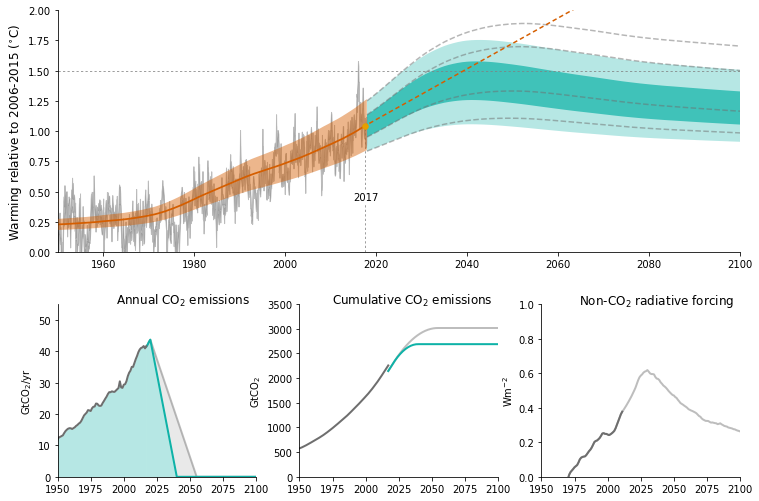

In [155]:
# fig_all = figures_plot('all')
fig_co2_change = figures_plot('co2_change')
#fig_rad_forc_change = figures_plot('rad_forc_change')
#fig_original = figures_plot('original')

# fig_all.savefig('./examplefigs/stuart_design/SPM_fig_all.pdf', dpi = 300)
# fig_co2_change.savefig('./examplefigs/stuart_design/SPM_fig_co2_change.pdf', dpi = 300)
# fig_rad_forc_change.savefig('./examplefigs/stuart_design/SPM_fig_rad_forc_change.pdf', dpi = 300)
# fig_original.savefig('./examplefigs/stuart_design/SPM_fig_original.pdf', dpi = 300)

plt.show()